In [1]:
from osgeo import gdal
import sklearn as sk
import input_test
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg


In [3]:
# ./modelos_clases_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_100.ckpt
batch_size = 237299/100
dropout = 0.5
n_classes = 4
epsilon=1e-08
epochs=11
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.9
bands=7
epsilon=1e-08
learning_rate = 0.00001

In [4]:
dataset= input_test.read_data_sets('','/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_validation/11x11_2',
                                   bands,n_clases=n_classes)
# /media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_11x11

237299


In [5]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [6]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,11,11,bands])
y = tf.placeholder("float", [None, n_classes])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([2, 2, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([2, 2, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()
saver = tf.train.Saver()

In [7]:
def continue_training (model_path,size,size_text, ep):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        
        for i in range (1,int(size/batch_size)*int(epochs)):
            
            batch_xs, batch_ys = dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(size/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0
                y_p = tf.argmax(pred,1)
                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = size_text/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                    predictions = sess.run([correct_pred], feed_dict={x: t_batch_xs,
                                                                      y: t_batch_ys, keep_prob: 1.})
                    prediction  = tf.argmax(pred,1)
                    y_true = np.argmax(t_batch_ys,1)
                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
                                                        keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

                a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
                a3=a3.eval()
                accuaracy,matrix=precision_measure(a3)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a3)
        print (matrix)
        model= "./modelos_11x11/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(batch_size)+"_ep_"+str(ep)+".ckpt"
        save_path = saver.save(sess, model)
        print ("model saved")
        print (model)
        sess.close()

In [8]:
def precision_measure (a2):
    pro=0
    b2=a2.astype(float)

    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    for l in range (n_classes):
        if(b2[l][l]!=np.nan):
            pro+=b2[l][l]
        
    pro=pro/n_classes 
    return pro,b2

In [9]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/batch_size
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return matrix

In [10]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/batch_size
######################################################
###   Test 
######################################################
        while step < limit:
            t_batch_xs, t_batch_ys = dataset.validation.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            pred_1 = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=pred_1              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, pred_1))
            step+=1
            
            
        
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        print (a)
                       
        accuaracy,matrix=precision_measure(a)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)        
        print (matrix)
        sess.close()
    return matrix

In [13]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
# 45112
# 5008


##########################################################            
###   TRAIN
##########################################################
    
    # Keep training until reach max iterations
    for i in range (1,int(45112/batch_size)*int(epochs)): 
        
        batch_xs, batch_ys = dataset.train.next_batch(batch_size)
        # Fit training using batch data
        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(45112/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 5008/batch_size
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                prediction  = tf.argmax(pred,1)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
            a3=a3.eval()
            accuaracy,matrix=precision_measure(a3)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################
#           %matplotlib
#           import matplotlib.pyplot as plt
#           l=np.arange(0.0, epochs-1, 1.)
#           plt.plot(val,l, 'r--') 
    print "Optimization Finished!"    
    model= "./modelos_11x11/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_Bathsize_"+str(batch_size)+".ckpt"
    np.set_printoptions(precision=3, suppress=True)
    print (a3)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    sess.close()        
        

Start Train
time this epoch= 0.03769
test accuracy 0.627983097815
time this epoch= 0.035692
test accuracy 0.85123626021
time this epoch= 0.039304
test accuracy 0.868092657901
time this epoch= 0.03801
test accuracy 0.874566627401
time this epoch= 0.037801
test accuracy 0.881318448768
time this epoch= 0.038671
test accuracy 0.889305010545
time this epoch= 0.039592
test accuracy 0.890942644416
time this epoch= 0.039371
test accuracy 0.895652269248
time this epoch= 0.038316
test accuracy 0.897468754307
time this epoch= 0.037145
test accuracy 0.899465502115
Optimization Finished!
[[1196   28   41   60]
 [  11 1084  157   23]
 [   8  103 1024    4]
 [  25   28   13 1156]]
[[ 0.903  0.021  0.031  0.045]
 [ 0.009  0.85   0.123  0.018]
 [ 0.007  0.09   0.899  0.004]
 [ 0.02   0.023  0.011  0.946]]
Model saved in file: ./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_0.0001_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_451.ckpt


# Prueba de las primeras 30 epocas

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


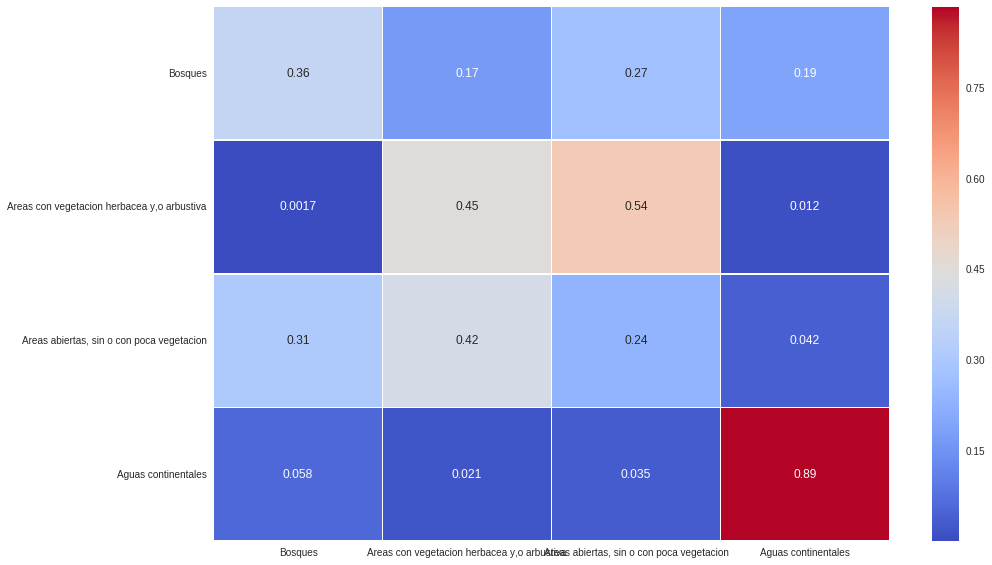

In [14]:
matrix=test_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_451.ckpt',
                  5008)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Esto es una prueba

# Validacion Primeras 30 epocas

Model successfully restored
sklearn martix
[[  237    72 12869    33]
 [  734  3193  9190   119]
 [    6    89    42     0]
 [ 7965    26  1820  3403]]
test accuracy 0.205818713591
[[ 0.018  0.005  0.974  0.002]
 [ 0.055  0.241  0.694  0.009]
 [ 0.044  0.65   0.307  0.   ]
 [ 0.603  0.002  0.138  0.258]]


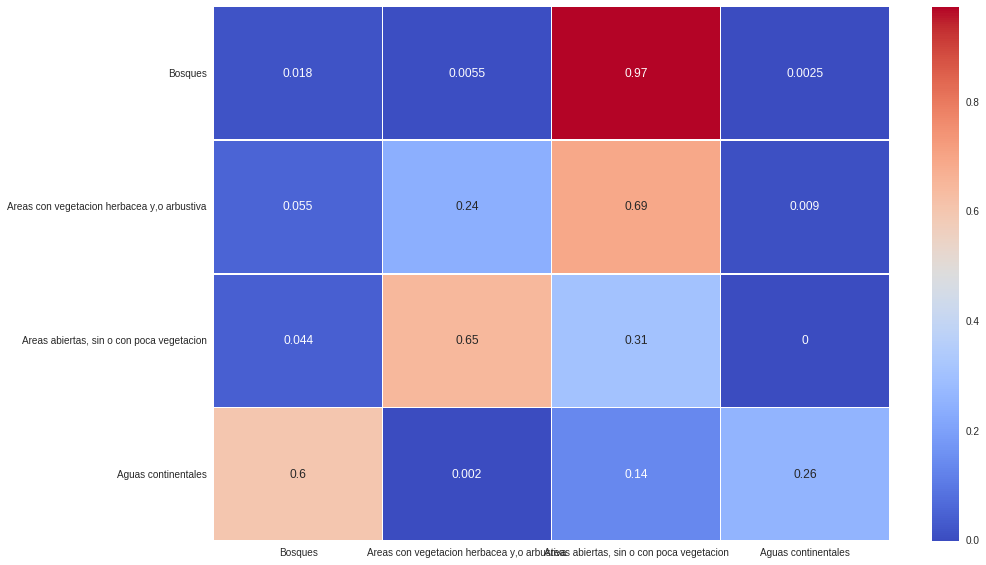

In [12]:
matrix=validation_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_451.ckpt', size =40246)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Restaurar modelos

## Redefinir variables

In [16]:
continue_training('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_451.ckpt',
                  45112,5008,60)

Model successfully restored
time this epoch= 0.038966
test accuracy 0.485988092223
time this epoch= 0.038947
test accuracy 0.492291504905
time this epoch= 0.03824
test accuracy 0.496180201686
time this epoch= 0.037109
test accuracy 0.500664591926
time this epoch= 0.037337
test accuracy 0.502186593479
time this epoch= 0.038303
test accuracy 0.506617715418
time this epoch= 0.038801
test accuracy 0.512704163031
time this epoch= 0.037133
test accuracy 0.518843322687
time this epoch= 0.03751
test accuracy 0.524268650345
time this epoch= 0.038177
test accuracy 0.53027729696
time this epoch= 0.038399
test accuracy 0.536880260039
time this epoch= 0.037774
test accuracy 0.541324043006
time this epoch= 0.036449
test accuracy 0.547293553296
time this epoch= 0.036219
test accuracy 0.553549437152
time this epoch= 0.036983
test accuracy 0.555573202644
time this epoch= 0.037344
test accuracy 0.56179511143
time this epoch= 0.038851
test accuracy 0.564439131686
time this epoch= 0.038324
test accuracy 0

# Prueba en la epoca 60

Model successfully restored
test accuracy 0.627410200768
[[1134   66  304  136]
 [   3  580  288    7]
 [  22  514  425   40]
 [  82   78  225 1057]]
[[ 0.691  0.04   0.185  0.083]
 [ 0.003  0.661  0.328  0.008]
 [ 0.022  0.513  0.425  0.04 ]
 [ 0.057  0.054  0.156  0.733]]


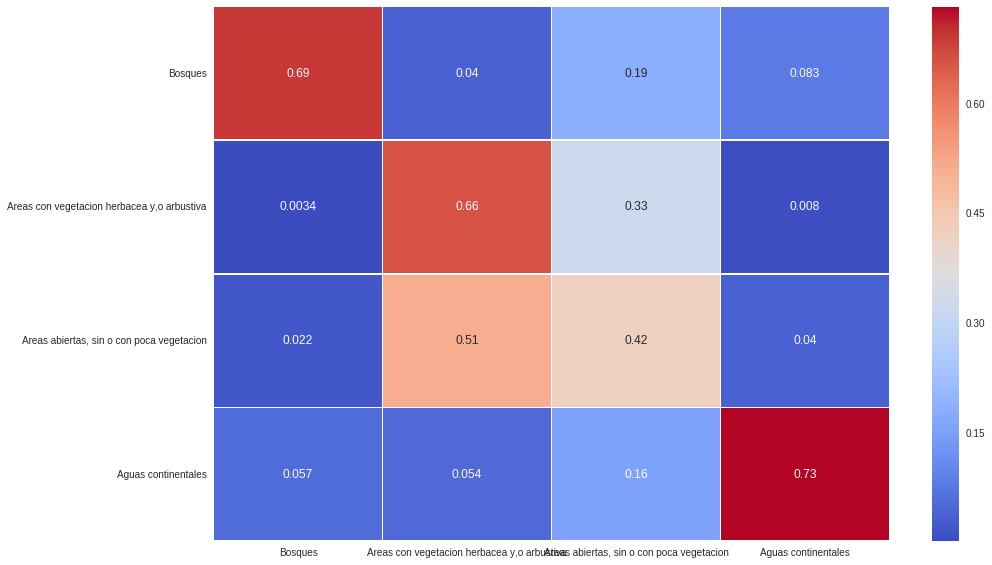

In [18]:
matrix=test_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_60.ckpt',
                  5008)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion en la epoca 60

Model successfully restored
sklearn martix
[[ 9227   147  2702  1144]
 [  174  4103  8460   491]
 [    2    74    57     1]
 [ 1566    28   784 10838]]
test accuracy 0.563393186443
[[ 0.698  0.011  0.204  0.087]
 [ 0.013  0.31   0.64   0.037]
 [ 0.015  0.552  0.425  0.007]
 [ 0.118  0.002  0.059  0.82 ]]


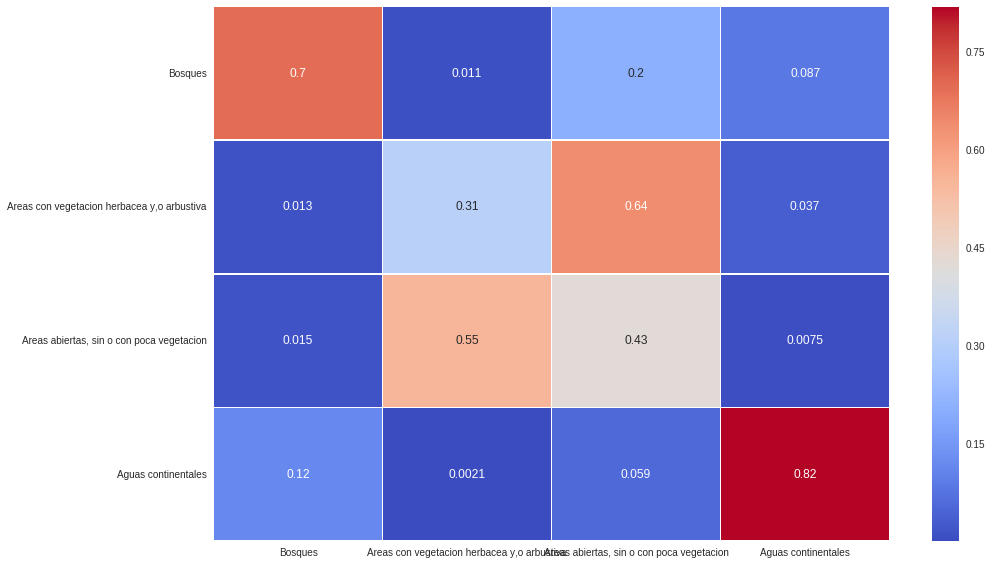

In [13]:
matrix=validation_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_60.ckpt', size =40246)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [15]:
continue_training('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_60.ckpt',
                  45112,5008,90)

Model successfully restored
time this epoch= 0.039031
test accuracy 0.606570601484
time this epoch= 0.038086
test accuracy 0.612418663558
time this epoch= 0.03829
test accuracy 0.615998230435
time this epoch= 0.037201
test accuracy 0.619125227887
time this epoch= 0.037887
test accuracy 0.625431615215
time this epoch= 0.036305
test accuracy 0.631443260665
time this epoch= 0.038365
test accuracy 0.637257764779
time this epoch= 0.038262
test accuracy 0.641254692311
time this epoch= 0.038432
test accuracy 0.644338432936
time this epoch= 0.038525
test accuracy 0.648599654557
time this epoch= 0.03686
test accuracy 0.652288304997
time this epoch= 0.038866
test accuracy 0.656271025445
time this epoch= 0.040305
test accuracy 0.660214915913
time this epoch= 0.036839
test accuracy 0.667195864445
time this epoch= 0.037606
test accuracy 0.674245970787
time this epoch= 0.038664
test accuracy 0.676951302047
time this epoch= 0.038935
test accuracy 0.684382033027
time this epoch= 0.038141
test accuracy

# Prueba en la epoca 93

Model successfully restored
test accuracy 0.735578391064
[[1151   40  159   76]
 [   3  835  319    8]
 [   6  292  585   22]
 [  86   74  174 1131]]
[[ 0.807  0.028  0.112  0.053]
 [ 0.003  0.717  0.274  0.007]
 [ 0.007  0.323  0.646  0.024]
 [ 0.059  0.051  0.119  0.772]]


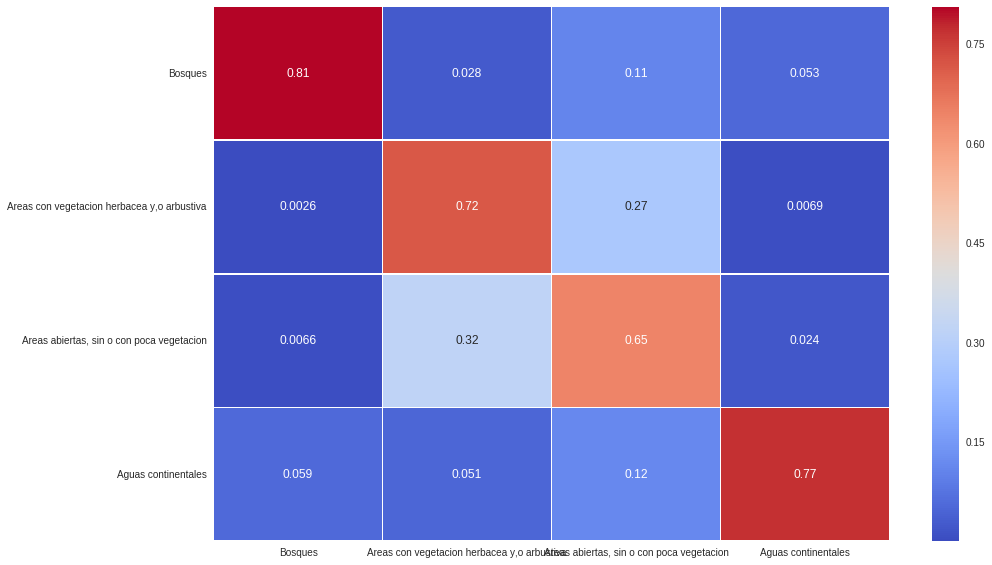

In [16]:
matrix=test_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_90.ckpt',
                  5008)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion en la epoca 93

Model successfully restored
sklearn martix
[[12556   207   336   141]
 [  249  4791  7652   508]
 [   11    59    59     1]
 [ 1599    25   329 11275]]
test accuracy 0.654374425271
[[ 0.948  0.016  0.025  0.011]
 [ 0.019  0.363  0.58   0.038]
 [ 0.085  0.454  0.454  0.008]
 [ 0.121  0.002  0.025  0.852]]


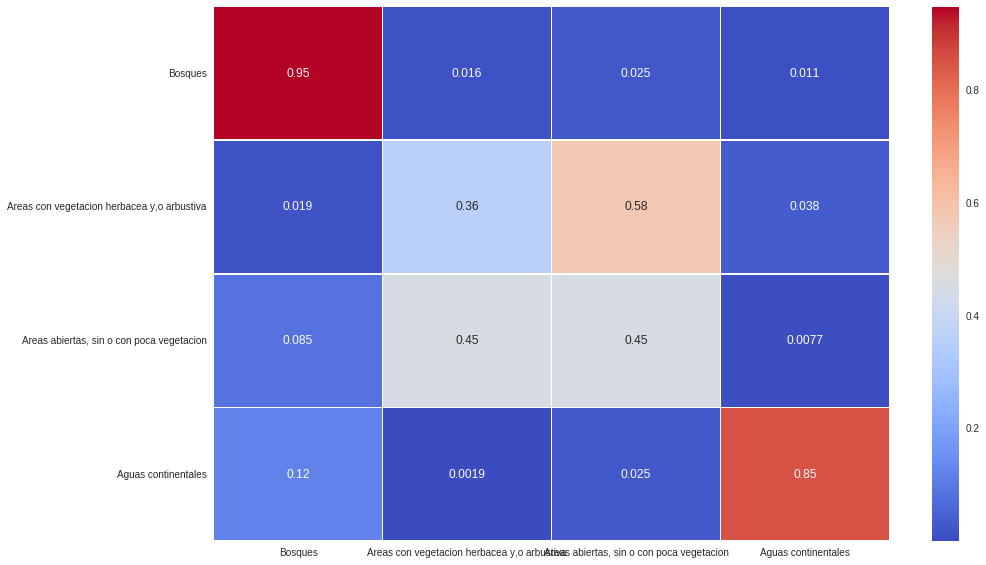

In [14]:
matrix=validation_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_90.ckpt', size =40246)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion prueba de matrices de confusion

Model successfully restored
sklearn martix
[[12537   213   335   144]
 [  249  4826  7627   514]
 [   12    56    61     1]
 [ 1600    26   334 11263]]
test accuracy 0.658464578037
[[ 0.948  0.016  0.025  0.011]
 [ 0.019  0.365  0.577  0.039]
 [ 0.092  0.431  0.469  0.008]
 [ 0.121  0.002  0.025  0.852]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


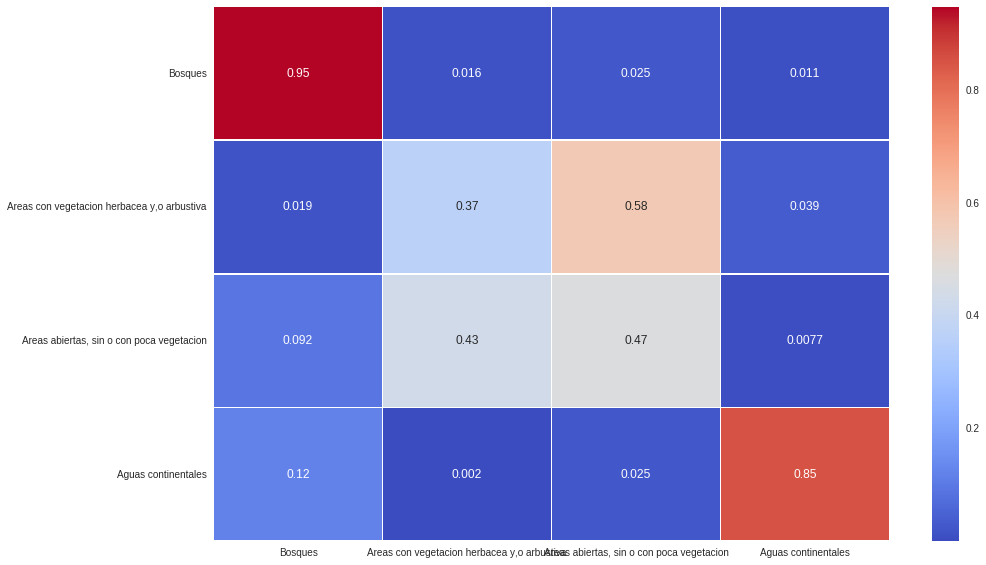

In [11]:
matrix=validation_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_90.ckpt', size =40246)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

Model successfully restored
sklearn martix
[[126996   1063   1208   1630]
 [  4435  17048  55251  15664]
 [    24     19     70     23]
 [  1766     10     97  11474]]
test accuracy 0.632269705457
[[ 0.97   0.008  0.009  0.012]
 [ 0.048  0.185  0.598  0.17 ]
 [ 0.176  0.14   0.515  0.169]
 [ 0.132  0.001  0.007  0.86 ]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


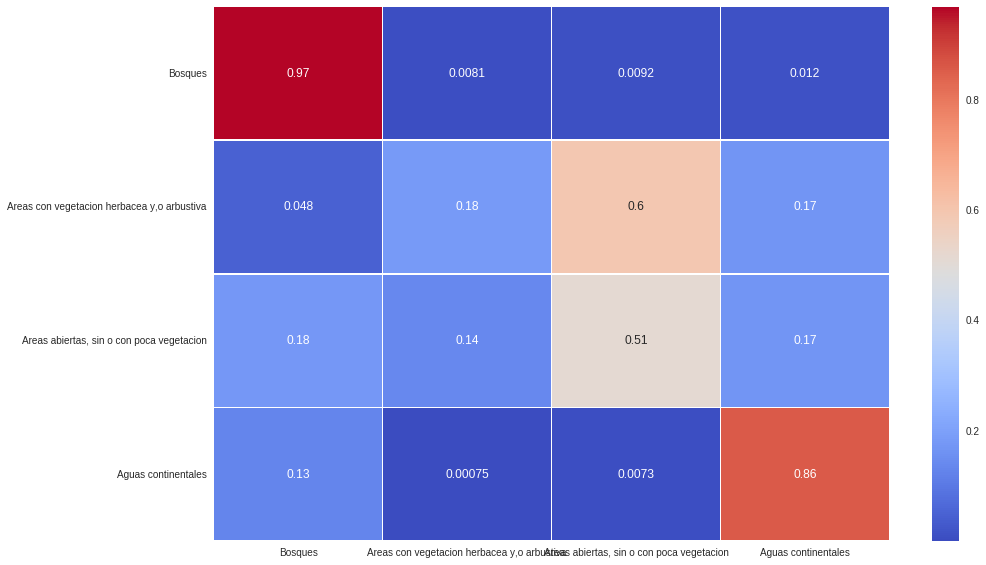

In [12]:
matrix=validation_model('./modelos_11x11/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_bath_451_ep_90.ckpt', size =237299)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [13]:
print (matrix)


[[ 0.97   0.008  0.009  0.012]
 [ 0.048  0.185  0.598  0.17 ]
 [ 0.176  0.14   0.515  0.169]
 [ 0.132  0.001  0.007  0.86 ]]
